In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlp import test_mlp


#from pybrain.datasets.supervised import SupervisedDataSet
#from pybrain.tools.shortcuts import buildNetwork
#from pybrain.supervised.trainers import BackpropTrainer
%matplotlib inline

# Loading the data

In [2]:
data = pd.read_csv('data.1_min.csv',names=['Date','Prices'],header=0)
data

,Date,Prices
0,1990-01-08 15:33:00,411.250000
1,1990-01-08 15:34:00,411.750000
2,1990-01-08 15:35:00,411.500000
3,1990-01-08 15:36:00,411.500000
4,1990-01-08 15:37:00,411.250000
5,1990-01-08 15:38:00,411.000000
6,1990-01-08 15:39:00,411.250000
7,1990-01-08 15:40:00,411.000000
8,1990-01-08 15:41:00,411.000000
9,1990-01-08 15:42:00,411.000000


## Plotting the data

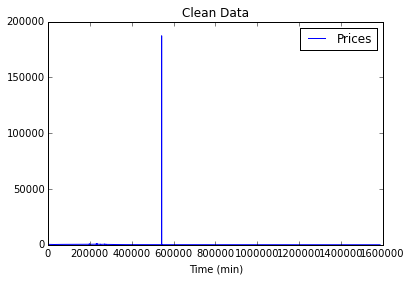

In [3]:
plt.plot(data.Prices)
plt.legend(['Prices'])
plt.title('Clean Data')
plt.xlabel('Time (min)')

We remove the Dirac

In [4]:
data_clean=data[data.Prices<10000]

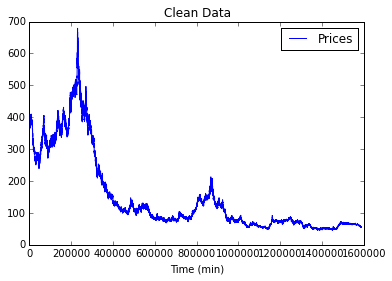

In [5]:
plt.plot(data_clean.Prices)
plt.legend(['Prices'])
plt.title('Clean Data')
plt.xlabel('Time (min)')

# Artificial Neural Network  with Horizon 1

To perform a Multi Layer Perceptron, we first need to normalize the data. We decide to do a Min/Max normalization. A Z-Score normalization can also be done.

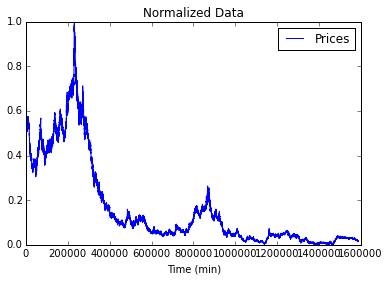

In [6]:
dat=data_clean.Prices
dmax=dat.max()
dmin=dat.min()
dmin
#mean = dat.mean()
#std=dat.std()
dat=(dat-dmin)/(dmax-dmin)
#dat=(dat-mean)/std
plt.plot(dat)
plt.legend(['Prices'])
plt.title('Normalized Data')
plt.xlabel('Time (min)')

The data are normalized. Now we split the set into a training set, a validation set and a test set. The test set size is 20% of the dataset, the validation set size is $\frac{20}{100}\frac{80}{100}*100$% of the dataset size.

In [7]:

n=len(dat)
train=dat[:int(n*80/100)]
#mean_train = train.mean()
#std_train=train.std()
#train=(train-mean_train)/std_train


ntrain=train.shape[0]
val=train[int(ntrain*(80/100)):]
train=train[int(ntrain*(80/100)):]

test=dat[int(n*80/100):]
#mean_test = test.mean()
#std_test=test.std()
#test=(test-mean_test)/std_test

The goal here is to predict the next minute prices by knowing the last $T-1$ values. To do this, we use a Multi Layer Perceptron with $T-1$ inputs, 1 hidden layer, 1 output. We are taking $T=60$. Ideally we should as a trainning set a moving window of size $T-1$ that moves every minute, but that will generate a heavy training set. Hence we decide to take as training examples disjoint vectors of size $T-1$.

In [8]:
T=60
ntrain=train.shape[0]
l=ntrain//T
X=train[:l*T].reshape(l,T)
Xtrain=X[:,:T]
Ytrain=X[:,-1]
Ytrain=Ytrain.reshape(-1,1)



nval=val.shape[0]
lv=nval//T
Xv=val[:lv*T].reshape(lv,T)
Xval=Xv[:,:T]
Yval=Xv[:,-1]
Yval=Yval.reshape(-1,1)


ntest=test.shape[0]
lt=ntest//T
Xt=test[:lt*T].reshape(lt,T)
Xtest=Xt[:,:T]
Ytest=Xt[:,-1]
Ytest=Ytest.reshape(-1,1)


First, I wanted to use the PyBrain library to do the Neural Network (I have never used this library before). The network would be, as mentionned above, a network with a single hidden layer with 100 hidden neurons. The hidden activation function used is sigmoid function. As we are doing a regression, the output function is the linear function.


The problem is that running the training is too slow and to computationaly expensive for my CPU.  

In [46]:
input_size=Xtrain.shape[1]
target_size=1
ds = SupervisedDataSet(input_size , target_size )
ds.setField( 'input', Xtrain )
ds.setField( 'target', Ytrain )
hidden_size = 100
net = buildNetwork( input_size, hidden_size, target_size, bias = True )
trainer = BackpropTrainer( net, ds )
trainer.trainUntilConvergence( verbose = True, maxEpochs = 100, continueEpochs = 10 )

KeyboardInterrupt: 

I decide to use a GPU instance to run the ANN algorithm (Amazon Web Service). PyBrain cannot be run with a GPU. The solution is to use the Theano Library. I took as a template the .py file 'mlp.py' from DeepLearning.net : http://deeplearning.net/tutorial/code/mlp.py. This template is usually used in my Deep Learning class. I modified the file to make it a Neural Network Regression with a linear activation function and an error rate defined by the mean squared error.  

In [9]:

datas = [ (Xtrain,Ytrain),(Xval,Yval),(Xtest,Ytest) ]

The codes does a backpropagation and a feed forward algorithm with a learning rate of 0.01, a L_2 penalty of 0.0001 and 100 hidden units. The algorithm is trained and validated during 50 epochs on minibatches of size 20.

In [132]:
res=test_mlp(datasets=datas,n_epochs=50,n_hidden=100)

... building the model
... training
epoch 1, train error 0.008041, validation error 0.005215
epoch 2, train error 0.007605, validation error 0.002853
epoch 3, train error 0.007557, validation error 0.002095
epoch 4, train error 0.007520, validation error 0.001794
epoch 5, train error 0.007485, validation error 0.001646
epoch 6, train error 0.007452, validation error 0.001555
epoch 7, train error 0.007419, validation error 0.001487
epoch 8, train error 0.007386, validation error 0.001429
epoch 9, train error 0.007354, validation error 0.001376
epoch 10, train error 0.007321, validation error 0.001327
epoch 11, train error 0.007289, validation error 0.001280
epoch 12, train error 0.007258, validation error 0.001236
epoch 13, train error 0.007226, validation error 0.001193
epoch 14, train error 0.007194, validation error 0.001152
epoch 15, train error 0.007163, validation error 0.001113
epoch 16, train error 0.007132, validation error 0.001075
epoch 17, train error 0.007101, validation er

The mean squared error for the normalized test set is 0.0000003515.

After denormalizing the test targets and our prediction, we can compare graphically the results.

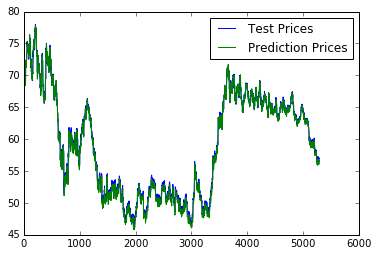

In [134]:
y=[res[i]*(dmax-dmin)+dmin for i in range(len(res))]
ytest=Ytest*(dmax-dmin)+dmin
plt.plot(ytest)
plt.plot(y)
plt.legend(['Test Prices','Prediction Prices'])